In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import logging

In [33]:
df = pd.read_csv('work_journal.csv', skipinitialspace=True)

In [34]:
# convert dates
for col in ['start', 'end']:
    df[col] = pd.to_datetime(df[col], format='%d.%m.%Y %H:%M')

In [35]:
# convert categories
df['category'] = df['category'].astype('category')
df['category'].cat.categories.tolist()

['admin', 'dev', 'report', 'research']

In [36]:
# check journal entry start is allways before end
violations = df[df['start'] >= df['end']]
if len(violations) > 0:
    logging.error('The following entries have a start time after the end time :\n')
    logging.error(violations)
    exit(1)

In [37]:
# check journal does not contains overlapping entries
# source: chatGPT
df_sorted = df.sort_values(['start', 'end']).copy()

prev_end = df_sorted['end'].shift()
overlap_mask = df_sorted['start'] < prev_end
overlaps = df_sorted[overlap_mask]
if len(overlaps) > 0:
    logging.error('The following entries overlap with others :\n')
    logging.error(overlaps)
    exit(1)

In [38]:
# feature engineering
df['duration_hours'] = (df['end'] - df['start']).dt.total_seconds() / 3600
df['start_week'] = df['start'].dt.to_period('W').dt.start_time

In [39]:
weekly_df = df.groupby(["start_week", "category"])["duration_hours"].sum().reset_index()
weekly_df_pivoted = weekly_df.pivot(index='start_week', columns='category', values='duration_hours').fillna(0).sort_index()
weekly_df_pivoted

category,admin,dev,report,research
start_week,,,,
2026-02-23,0.00,10.75,3.00,3.75
2026-03-02,0.25,12.00,0.50,2.75
2026-03-09,0.00,11.25,1.50,4.25
2026-03-16,0.00,13.00,2.00,2.00
2026-03-23,1.25,11.75,1.50,3.50
2026-03-30,0.00,11.50,1.75,3.75
2026-04-06,0.50,12.75,1.00,3.25
2026-04-13,0.50,10.50,2.00,4.00
2026-04-20,1.00,11.00,2.00,3.00


Text(0, 0.5, 'Hours')

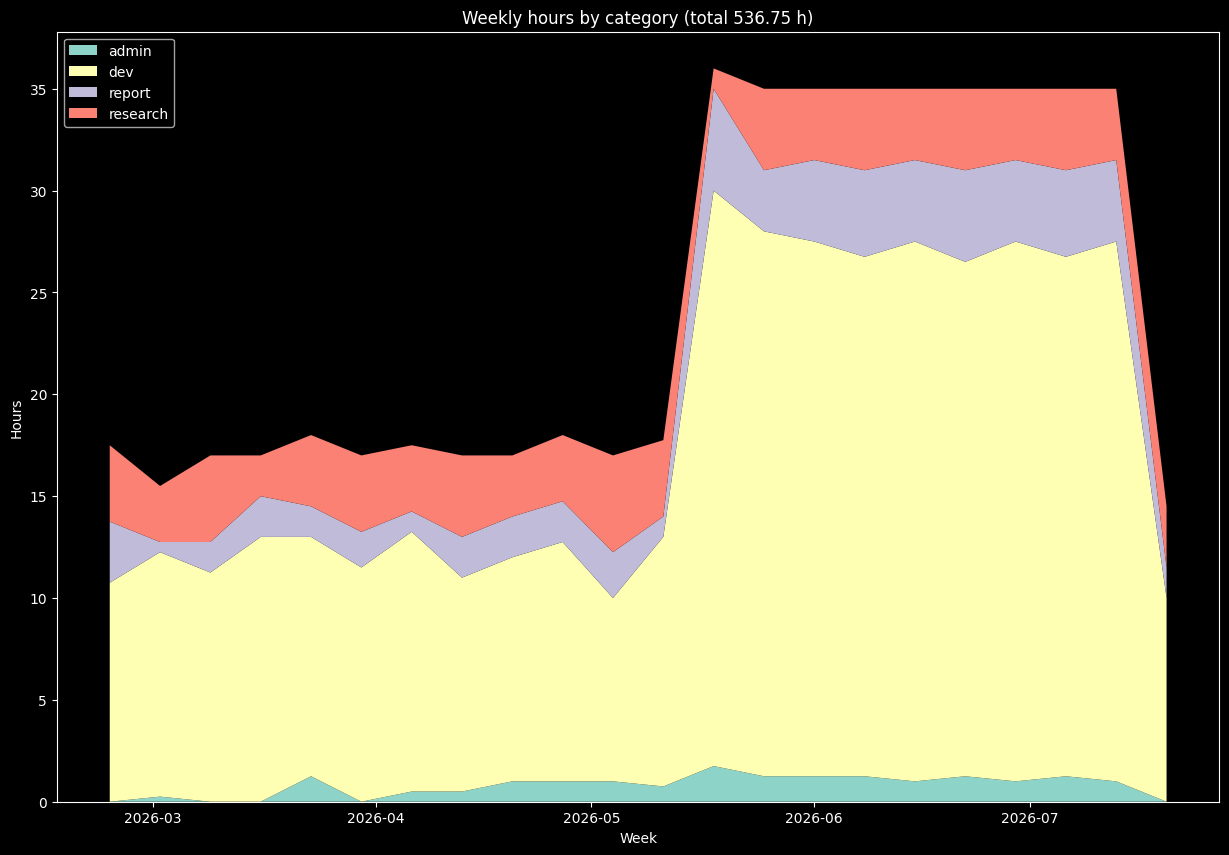

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.stackplot(
        weekly_df_pivoted.index.to_pydatetime(),
        weekly_df_pivoted.T.values,
        labels=[str(c) for c in weekly_df_pivoted.columns],
    )

ax.legend()
ax.set_title(f"Weekly hours by category (total {df['duration_hours'].sum():.2f} h)")
ax.set_xlabel("Week")
ax.set_ylabel("Hours")
